## Libraries

In [8]:
import cProfile
import pstats
import numpy as np
import pandas as pd
from timeit import default_timer as timer
from datetime import timedelta
from matplotlib import pyplot as plt

from smooth_output import smooth_fourier
from Jcb import calc_basis_matrix
from R import calc_penalty_matrix
from cordex_discrete import cordex_discrete
from cordex_continuous import cordex_continuous
from cordex_continuous_v2 import cordex_continuous_v2
from plot_fun import subplot_results
# from bayesian_continuous import bo_loop
from Jcb import Jcb
from R import R
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# %load_ext autotime

## Helpers

In [9]:
def calc_cr(optimality, results, runs):
    Z = np.hstack((np.ones((runs, 1)), results@J_cb))
    M = Z.T @ Z
    if optimality == 'D':
        return np.linalg.det(M)
    elif optimality == 'A':
        return np.trace(np.linalg.inv(M))
    else:
        return np.infty

In [10]:
def run_grid_search(runs, n_x, scalars, optimality, J_cb, R_0, epochs,
             lamb_ridge=np.logspace(-5,5, num=10), lamb_smooth=np.logspace(-5,5, num=10)):
    results_free, _ = cordex_continuous(runs=runs,
                                          f_list=n_x,
                                          scalars=scalars,
                                          optimality=optimality,
                                          J_cb=J_cb,
                                          R_0=None,
                                          smooth_pen=0,
                                          ridge_pen=0,
                                          epochs=epochs,
                                          final_pass_iter=epochs)
    results_free_cr = calc_cr(optimality, results_free, runs)

    criteria_list = np.empty((len(lamb_ridge), len(lamb_smooth)))
    with tqdm(total=len(lamb_ridge)*len(lamb_smooth)) as pbar:
        for i,l in enumerate(lamb_ridge):
            for j,k in enumerate(lamb_smooth):
                results_smooth_ridge, _ = cordex_continuous(runs=runs,
                                                            f_list=n_x,
                                                            scalars=scalars,
                                                            optimality=optimality,
                                                            J_cb=J_cb,
                                                            R_0=R_0,
                                                            smooth_pen=k,
                                                            ridge_pen=l,
                                                            epochs=epochs,
                                                            final_pass_iter=epochs,
                                                            main_bar=False)
                best_cr_smooth_ridge = calc_cr(optimality, results_smooth_ridge, 5)
                idx_l = np.where(lamb_ridge == l)[0][0]
                idx_k = np.where(lamb_smooth == k)[0][0]
                criteria_list[idx_l, idx_k] = best_cr_smooth_ridge
                pbar.update(1)
    if optimality == 'A':
        criteria_eff_list = np.round(results_free_cr / criteria_list , 2)
        # criteria_eff_list = np.round(np.exp(np.log(criteria_list) - np.log(results_free_cr)) * 100, 2)
    else:
        criteria_eff_list = np.round(criteria_list / results_free_cr , 2)
        # criteria_eff_list = np.round(np.exp(np.log(results_free_cr) - np.log(criteria_list)) * 100, 2)
    return criteria_list, criteria_eff_list

In [11]:
def plot_contour(crit_list, lamb_ridge, lamb_smooth, name='Efficiency'):
    crit_smooth = gaussian_filter(crit_list, sigma=1)
    fig, ax = plt.subplots()
    cs = ax.contourf(lamb_ridge, lamb_smooth, crit_smooth, cmap='plasma', vmin=0, vmax=1)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Smooth penalty (log scale)')
    ax.set_ylabel('Ridge penalty (log scale)')
    ax.clabel(cs, inline=True, fontsize=10, fmt='')
    cbar = fig.colorbar(cs)
    cbar.set_label(f'{name}', rotation=270, labelpad=15, fontsize=12)
    plt.show()

In [12]:
def plot_3d(crit_list, lamb_ridge, lamb_smooth, name='Efficiency'):
    xx, yy = np.meshgrid(lamb_ridge, lamb_smooth)
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'surface'}]])

    fig.add_trace(go.Surface(x=xx, y=yy, z=crit_list, colorscale='plasma', cmin=0, cmax=1, showlegend=False), 1, 1)

    fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor="limegreen", project_z=True))
    fig.update_layout(scene=dict(xaxis=dict(title='Ridge λ', type='log', tickformat='.0e'),
                                 yaxis=dict(title='Smoothness λ', type='log', tickformat='.0e'),
                                 zaxis=dict(title=name, tickformat='0%')))
    fig.update_layout(title=name)
    fig.update_layout(coloraxis=dict(colorbar=dict(title=None)))
    fig.update_traces(showscale=False)
    fig.show()
    fig.write_image(f"{name}.png")

## Settings

In [6]:
epochs = 100
n_x = [4]
n_b = [3]
scalars = 0
J_cb = Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(n_x, n_b)])
R_0 = R(*[calc_penalty_matrix(n_b=b) for b in n_b])

## Comparrissons

## A-optimality

In [7]:
runs = 10
start = timer()
results_A_free, _ = cordex_continuous(runs=runs,
                                     f_list=n_x,
                                     scalars=scalars,
                                     optimality='A',
                                     J_cb=J_cb,
                                     R_0=None,
                                     smooth_pen=0,
                                     ridge_pen=0,
                                     epochs=epochs,)
end = timer()
best_cr_A_free = calc_cr('A', results_A_free, runs)
print(f"Optimality: {'A'}"
      f"\nBest criterion: {np.round(best_cr_A_free,3)}"
      f"\nExecution time (s): {timedelta(seconds=end-start)}")

 18%|█▊        | 18/100 [00:01<00:08, 10.13it/s]


KeyboardInterrupt: 

## D-optimality

In [ ]:
runs = 7
start = timer()
results_D_free, _ = cordex_continuous(runs=runs,
                                      f_list=n_x,
                                      scalars=scalars,
                                      optimality='D',
                                      J_cb=J_cb,
                                      R_0=None,
                                      smooth_pen=0,
                                      ridge_pen=0,
                                      epochs=epochs,)
end = timer()

best_cr_D_free = calc_cr('D', results_D_free, runs)
print(f"Optimality: {'D'}"
      f"\nBest criterion: {np.round(best_cr_D_free,3)}"
      f"\nExecution time (s): {timedelta(seconds=end-start)}")

In [ ]:
subplot_results(sub_x=3, sub_y=3, T=np.linspace(0, 1, 100), results=results_D_free)

---

In [ ]:
lamb_ridge=np.logspace(-5, 5, num=10)
lamb_smooth=np.logspace(-5, 5, num=10)

In [ ]:
criteria_list_A, criteria_eff_list_A = run_grid_search(runs=5,
                                                   n_x=n_x,
                                                   scalars=scalars,
                                                   optimality='A',
                                                   J_cb=J_cb,
                                                   R_0=R_0,
                                                   epochs=100,
                                                   lamb_ridge=lamb_ridge,
                                                   lamb_smooth=lamb_smooth)

In [ ]:
criteria_list_D, criteria_eff_list_D = run_grid_search(runs=5,
                                                       n_x=n_x,
                                                       scalars=scalars,
                                                       optimality='D',
                                                       J_cb=J_cb,
                                                       R_0=R_0,
                                                       epochs=100,
                                                       lamb_ridge=lamb_ridge,
                                                       lamb_smooth=lamb_smooth)

In [ ]:
plot_3d(criteria_eff_list_A, lamb_ridge=lamb_ridge, lamb_smooth=lamb_smooth, name='A - Efficiency')

In [ ]:
plot_3d(criteria_eff_list_D, lamb_ridge=lamb_ridge, lamb_smooth=lamb_smooth, name='D - Efficiency')

In [ ]:
R_0

---

In [ ]:
plot_contour(criteria_eff_list_A, lamb_ridge, lamb_smooth, name='Efficiency')

In [ ]:
plot_contour(criteria_eff_list_D, lamb_ridge, lamb_smooth, name='Efficiency')

## Findings
### For A optimality
- We want to have small smooth_pen and large ridge_pen
### For D optimality
- We want to have large smooth_pen and large ridge_pen

In [ ]:
start = timer()
results_A_free, _ = cordex_continuous(runs=5,
                                     f_list=n_x,
                                     scalars=scalars,
                                     optimality='A',
                                     J_cb=J_cb,
                                     R_0=None,
                                     smooth_pen=0,
                                     ridge_pen=0,
                                     epochs=epochs,)
end = timer()

best_cr_A_free = calc_cr('A', results_A_free, 5)
print(f"Optimality: {'A'}"
      f"\nBest criterion: {np.round(best_cr_A_free,3)}"
      f"\nExecution time (s): {timedelta(seconds=end-start)}")

In [ ]:
start = timer()
results_A_pen, _ = cordex_continuous(runs=5,
                                      f_list=n_x,
                                      scalars=scalars,
                                      optimality='A',
                                      J_cb=J_cb,
                                      R_0=R_0,
                                      smooth_pen=4e0,
                                      ridge_pen=4e0,
                                      epochs=epochs,)
end = timer()

best_cr_A_pen = calc_cr('A', results_A_pen, 5)
print(f"Optimality: {'A'}"
      f"\nBest criterion: {np.round(best_cr_A_pen,3)}"
      f"\nBest free crit: {np.round(best_cr_A_free,3)}"
      f"\nEfficiency prc: {np.round(np.exp(np.log(best_cr_A_free) - np.log(best_cr_A_pen)) * 100, 2)}"
      f"\nExecution time (s): {timedelta(seconds=end-start)}")

## EXAMPLES WITH D-opt

In [ ]:
runs = 4
epochs = 100
n_x = [4]
n_b = [2]
scalars = 0
J_cb = Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(n_x, n_b)])
R_0 = R(*[calc_penalty_matrix(n_b=b) for b in n_b])

In [ ]:
start = timer()
results_D_free, _ = cordex_continuous(runs=runs,
                                     f_list=n_x,
                                     scalars=scalars,
                                     optimality='A',
                                     J_cb=J_cb,
                                     R_0=None,
                                     smooth_pen=0,
                                     ridge_pen=0,
                                     epochs=100,
                                      final_pass_iter=100)
end = timer()
print(_)
best_cr_D_free = calc_cr('D', results_D_free, runs=runs)
print(f"Optimality: {'D'}"
      f"\nBest criterion: {np.round(best_cr_D_free,5)}"
      f"\nExecution time (s): {timedelta(seconds=end-start)}")

In [ ]:
subplot_results(sub_x=2, sub_y=2, results=results_D_free, T=np.linspace(0, 1, 1000))

In [110]:
runs = 4
n_x = [16]
n_b = [20]
scalars = 0
optimality = 'D'
J_cb = Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(n_x, n_b)])
R_0 = R(*[calc_penalty_matrix(n_b=b) for b in n_b])
smooth_pen = 0
ridge_pen = 0.87

In [111]:
start = timer()
results_D_pen, _ = cordex_continuous(runs=runs,
                                      f_list=n_x,
                                      scalars=scalars,
                                      optimality=optimality,
                                      J_cb=J_cb,
                                      R_0=None,
                                      smooth_pen=smooth_pen,
                                      ridge_pen=ridge_pen,
                                      epochs=100,
                                      estimator='Bayes',
                                      final_pass_iter=100)
end = timer()
print(_)
best_cr_D_pen = calc_cr(optimality, results_D_pen, runs=runs)
print(f"Optimality: {optimality}"
      f"\nBest criterion: {best_cr_D_pen}"
      f"\nExecution time (s): {timedelta(seconds=end-start)}")

100%|██████████| 100/100 [00:09<00:00, 10.04it/s]


0.3990144247418294
Optimality: D
Best criterion: 0.0
Execution time (s): 0:00:13.453996


In [104]:
Z = np.concatenate((np.ones((runs,1)), results_D_pen @ J_cb), axis=1)
M = Z.T @ Z + smooth_pen * R_0 + ridge_pen * np.eye(Z.shape[1])
np.linalg.det(M)

1.5999964952270442

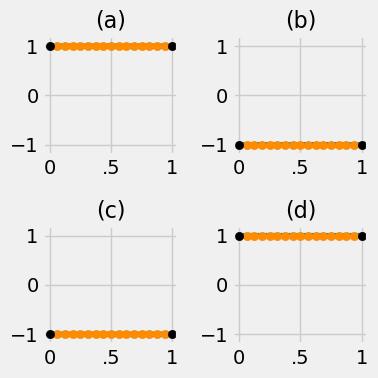

In [112]:
subplot_results(sub_x=2, sub_y=2, results=results_D_pen, T=np.linspace(0, 1, 10000))

---

## Plots

In [ ]:
subplot_results(sub_x=2, sub_y=2, results=results_A_free, T=np.linspace(0, 1, 1000))

In [ ]:
subplot_results(sub_x=3, sub_y=2, results=results_A_pen, T=np.linspace(0, 1, 1000))

In [ ]:
subplot_results(sub_x=3, sub_y=2, results=results_D_free, T=np.linspace(0, 1, 1000))

In [ ]:
subplot_results(sub_x=3, sub_y=2, results=results_D_pen, T=np.linspace(0, 1, 1000))

In [ ]:
def mat_det(row, col):
    X = np.random.rand(row, col)
    Z = X.T @ X
    if np.isclose(np.linalg.det(Z), 0):
        return 0
    return np.linalg.det(Z)

In [ ]:
def mat_det_ridge(row, col, lamb):
    X = np.random.rand(row, col)
    Z = X.T @ X + lamb*np.identity((X.T @ X).shape[1])
    if np.isclose(np.linalg.det(Z), 0):
        return 0
    return np.linalg.det(Z)

In [ ]:
mat_det(30, 40)

In [ ]:
mat_det_ridge(30, 40, 1e-2)

In [113]:
A = np.array([[1, 2], [4, 5], [7, 8]]) # 3x2
B = np.array([[1, 2, 3], [4, 5, 6]]) # 2x3
A@B

array([[ 9, 12, 15],
       [24, 33, 42],
       [39, 54, 69]])

In [115]:
(B.T @ A.T).T

array([[ 9, 12, 15],
       [24, 33, 42],
       [39, 54, 69]])